# Analysis on the speakers data

In this notebook, we will go about exploring the preprocessed speakers data.

## 0. Setup

In [1]:
PATH_ROOT = 'data'
PATH_OUTPUT = 'output'
PATH_PARQUET = PATH_ROOT + '/project_datasets'
PATH_QUOTEBANK = PATH_ROOT + '/Quotebank'
PATH_TO_QUOTES = PATH_QUOTEBANK + '/quotes-{year}.json.bz2'

In [2]:
!pip install pyarrow

In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns

#NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models

import matplotlib.pyplot as plt
%matplotlib inline 

import pickle

C:\Users\steph\miniconda3\envs\ada\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## 1. Retrieve the preprocessed data

In [4]:
# Retrieve the preprocessed dataframe
retrieved_labeled_speakers = pd.read_parquet(PATH_OUTPUT + '/speakers_labeled.parquet.gzip')
display(retrieved_labeled_speakers)
display(retrieved_labeled_speakers.dtypes)
print('Length of final labeled speakers dataframe {}'.format(len(retrieved_labeled_speakers)))

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,label,candidacy,type,religion,age,age_group
id,,,,,,,,,,,,,,,,
Q23,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Great Britain, United States of America]",[male],1395141751,[None],W000178,"[politician, military officer, farmer, cartogr...",[independent politician],[None],George Washington,"[1792 United States presidential election, 178...",item,[Episcopal Church],289.0,>=100
Q42,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[United Kingdom],[male],1395737157,[White British],None,"[playwright, screenwriter, novelist, children'...",[None],[None],Douglas Adams,[None],item,[None],69.0,60s
Q1868,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Belgium],[male],1380367296,[None],None,"[writer, lawyer, librarian, information scient...",[None],[None],Paul Otlet,[None],item,[None],153.0,>=100
Q207,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[United States of America],[male],1395142029,[None],None,"[politician, motivational speaker, autobiograp...",[Republican Party],[None],George W. Bush,"[2000 United States presidential election, 200...",item,"[United Methodist Church, Episcopal Church, Me...",75.0,70s
Q297,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Spain],[male],1391704596,[None],None,[painter],[None],[None],Diego Velázquez,[None],item,[None],422.0,>=100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q106406560,[Barker Howard],None,[United States of America],[male],1397399351,[None],None,[politician],[None],[None],Barker B. Howard,[None],item,[None],NaN,None
Q106406571,[Charles Macomber],None,[United States of America],[male],1397399471,[None],None,[politician],[None],[None],Charles H. Macomber,[None],item,[None],NaN,None
Q106406588,None,[+1848-04-01T00:00:00Z],[None],[female],1397399751,[None],None,[None],[None],[None],Dina David,[None],item,[None],173.0,>=100


aliases                object
date_of_birth          object
nationality            object
gender                 object
lastrevid               int64
ethnic_group           object
US_congress_bio_ID     object
occupation             object
party                  object
academic_degree        object
label                  object
candidacy              object
type                   object
religion               object
age                   float64
age_group              object
dtype: object

Length of final labeled speakers dataframe 9055981


## 2. Exploring speakers attributes

Let's check the distribution of some of the speakers attributes, that we could potentially use as features.

#### 2.1 - Speaker's academic degree

If we consider speakers that have *None* value in *academic_degree* as 'uneducated', we can calculate the portion of 'educated' speakers with respect to the 'uneducated'.

In [5]:
def check_academic_degree(va):
    return va[0] is not None

academic_degree_df = retrieved_labeled_speakers[retrieved_labeled_speakers.academic_degree.apply(check_academic_degree)]
nb_educated_speakers = len(academic_degree_df)
nb_uneducated_speakers = len(retrieved_labeled_speakers) - nb_educated_speakers

In [6]:
print('{} speakers with an academic degree'.format(nb_educated_speakers))
print('{} speakers with no academic degree'.format(nb_uneducated_speakers))
print('{:.3f} % of speakers are "educated"'.format(nb_educated_speakers / len(retrieved_labeled_speakers)))

99483 speakers with an academic degree
8956498 speakers with no academic degree
0.011 % of speakers are "educated"


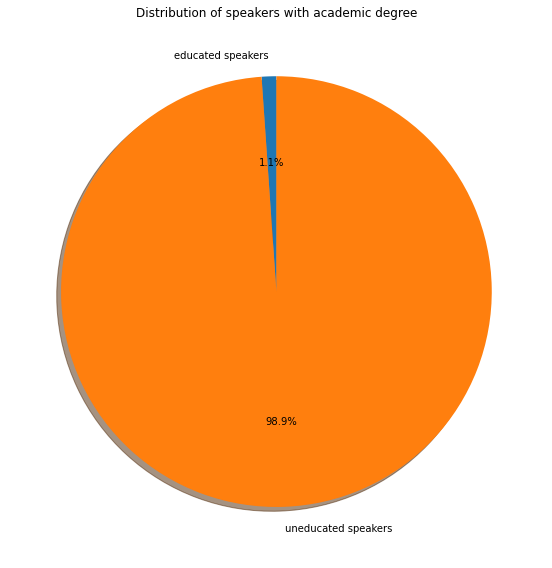

In [7]:
fig, ax = plt.subplots(figsize =  (14, 8))
ax.pie([nb_educated_speakers, nb_uneducated_speakers], labels=['educated speakers', 'uneducated speakers'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.set_title('Distribution of speakers with academic degree')

fig.tight_layout()

#### 2.2 - Speaker's occupation

Now let's see the distribution of the speakers' occupations.

In [8]:
df_speakers_occupations = retrieved_labeled_speakers.explode('occupation')

In [9]:
# The top 20 occupations
all_speakers_grouped_by_occupations = df_speakers_occupations.groupby(by='occupation').label.agg(['count'])
all_speakers_grouped_by_occupations = all_speakers_grouped_by_occupations.sort_values(by='count', ascending=False)
all_speakers_grouped_by_occupations.head(n=20)

,count
occupation,
researcher,1693607
politician,589893
association football player,309608
actor,267074
writer,262005
painter,161762
basketball player,132345
journalist,121720
university teacher,118013


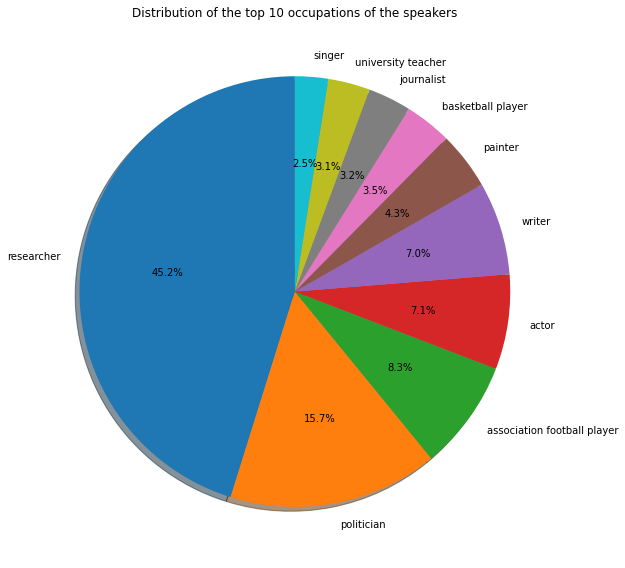

In [10]:
# Plot the distribution of the top 10 occupations
fig, ax = plt.subplots(figsize =  (14, 8))
ax.pie(all_speakers_grouped_by_occupations[:10]['count'],
       labels=all_speakers_grouped_by_occupations[:10].index, autopct='%1.1f%%',
       shadow=True, startangle=90)

ax.set_title('Distribution of the top 10 occupations of the speakers')

fig.tight_layout()

Someone like Donald Trump has a lot of occupations, which means he's going to have a lot of rows dedicated to him in the dataframe, since we exploded the *occupation* attribute.

In [11]:
# Some examples of prominent US politicans
display(retrieved_labeled_speakers[retrieved_labeled_speakers.label == 'Donald Trump'].occupation)
display(retrieved_labeled_speakers[retrieved_labeled_speakers.label == 'Barack Obama'].occupation)
display(retrieved_labeled_speakers[retrieved_labeled_speakers.label == 'Alexandria Ocasio-Cortez'].occupation)
display(retrieved_labeled_speakers[retrieved_labeled_speakers.label == 'Hillary Clinton'].occupation)
display(retrieved_labeled_speakers[retrieved_labeled_speakers.label == 'Bill Clinton'].occupation)

id
Q22686       [business magnate, investor, restaurateur, non...
Q27947481                              [physician, oncologist]
Name: occupation, dtype: object

id
Q76    [politician, lawyer, political writer, communi...
Name: occupation, dtype: object

id
Q55223040    [politician, political activist, community org...
Name: occupation, dtype: object

id
Q6294    [politician, lawyer, diplomat, writer, autobio...
Name: occupation, dtype: object

id
Q1124    [politician, lawyer, diplomat, autobiographer,...
Name: occupation, dtype: object

#### 2.3 - Speaker's gender

In [12]:
df_speakers_genders = retrieved_labeled_speakers.explode('gender')
all_speakers_grouped_by_gender = df_speakers_genders.groupby(by='gender').label.agg(['count'])
all_speakers_grouped_by_gender = all_speakers_grouped_by_gender.sort_values(by='count', ascending=False)
all_speakers_grouped_by_gender.head()

,count
gender,
male,5082907
female,1628261
transgender female,929
non-binary,363
transgender male,250


In [13]:
not_male_mask = all_speakers_grouped_by_gender.index != 'male' 
not_female_mask = all_speakers_grouped_by_gender.index != 'female'
len(all_speakers_grouped_by_gender[not_male_mask & not_female_mask]) / len(all_speakers_grouped_by_gender)

0.9459459459459459

The majority of speakers in the Quotebank are male (almost 70%). All other genders consitute about 5% of the speakers. So if we were to encode gender as features, we would have ['male', 'female', 'other'] where 'other' refers to the rest of the genders.

#### 2.4 - Speaker's age

In [14]:
# Don't need to explode the age here, we made sure each speaker has a unique age
all_speakers_age_groups = retrieved_labeled_speakers.groupby(by='age_group').label.agg(['count'])
all_speakers_age_groups

,count
age_group,
10s,23548
20s,252593
30s,335141
40s,353919
50s,385817
60s,403952
70s,380428
80s,277815
90s,262312


Text(0.5, 1.0, 'Distribution of the speakers age groups')

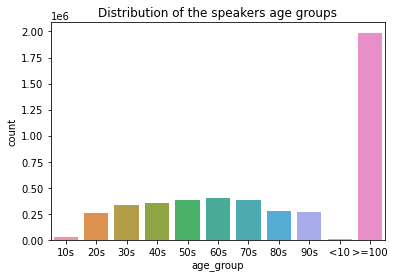

In [15]:
sns.barplot(x=all_speakers_age_groups.index, y=(all_speakers_age_groups['count']))
plt.title('Distribution of the speakers age groups')

Text(0.5, 1.0, 'Distribution of the speakers age groups in log scale')

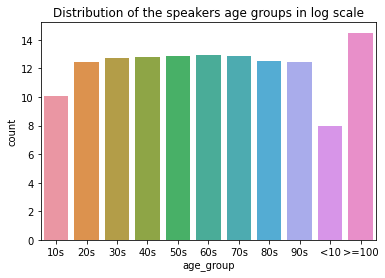

In [16]:
sns.barplot(x=all_speakers_age_groups.index, y=np.log(all_speakers_age_groups['count']))
plt.title('Distribution of the speakers age groups in log scale')

We can see that there a lot of the speakers are over 100 years old (probably quoted historical figures). And the distribution is more or less normally distributed around the 60s years old. To confirm let's take a look at speakers strictly less than 100 years old, i.e. contemporary speakers.

Text(0.5, 1.0, 'Distribution of contemporary speakers age groups')

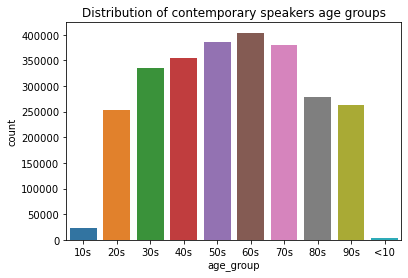

In [17]:
contemporary_groups_index = all_speakers_age_groups.index[:10]
contemporary_group = all_speakers_age_groups[all_speakers_age_groups.index.isin(contemporary_groups_index)]
sns.barplot(x=contemporary_group.index, y=(contemporary_group['count']))
plt.title('Distribution of contemporary speakers age groups')

## 3. Analyzing speakers profiles

The question we're trying to asnwer here is **how likely a speaker would speak about a certain topic**. For this we've narrowed it down to the topic of the **environment**. Let's explore.

### 3.1 - Retrieving the relevant quotations for the environment from 2018 to 2020 dataset

We have filtered the quotebank environment-related quotations from the 2018 to 2020 dataset and now we can retrieve them.

In [18]:
environment_quotations = []
ENVIRONMENT_RELATED_QUOTES = PATH_ROOT + '/quotes-{}-filtered.json.bz2'
BEGIN_YEAR = 2018
END_YEAR = 2020

for year in range(2018, END_YEAR + 1):
    environment_quotations.append(pd.read_json(path_or_buf=ENVIRONMENT_RELATED_QUOTES.format(year), compression='bz2', lines=True))
    
environment_quotations = pd.concat(environment_quotations)
# reset index to unique quoteID per quotation
environment_quotations = environment_quotations.set_index('quoteID')

# Keep the relevant columns for this part
environment_quotations = environment_quotations[['quotation', 'qids', 'numOccurrences']]
environment_quotations

,quotation,qids,numOccurrences
quoteID,,,
2018-06-21-001025,"A carbon tax, if the myriad of subsidies and r...",[],1
2018-03-06-005798,Alternative technologies outside North Carolin...,"[Q16150195, Q16150206, Q16197597, Q20894995, Q...",4
2018-06-12-008636,"As any farmer will tell you, June is a very di...","[Q5389146, Q57081966]",2
2018-11-14-010036,At 3AM when I stare at the ceiling and worry a...,"[Q1359387, Q21289642, Q21464307, Q22213056, Q3...",3
2018-02-16-012151,basic viewpoint is that if you ban fracking yo...,[],7
...,...,...,...
2020-04-03-059591,"Then, global emissions dropped immensely for a...",[Q21263801],1
2020-03-11-065584,These results demonstrate A.A.'s effectiveness...,"[Q21461335, Q28059471, Q6232322]",2
2020-01-21-085595,This concept of over-regulation is an interest...,"[Q10381179, Q3528685, Q513960, Q7804212, Q7804...",3


Now we'll narrow down the speakers that talked about the environment in that time period. Again we're faced with the **issue that there there could be multiple qids associated to the speaker of a quotation, so we're going to have to explode them**.

In [19]:
# Inner join between speakers dataframe and the environment-related quotations dataframe
environment_speakers = retrieved_labeled_speakers.merge(
    environment_quotations.explode('qids'), left_index=True, right_on='qids')
environment_speakers

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,label,candidacy,type,religion,age,age_group,quotation,qids,numOccurrences
quoteID,,,,,,,,,,,,,,,,,,,
2018-03-05-070476,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[United States of America],[male],1395142029,[None],None,"[politician, motivational speaker, autobiograp...",[Republican Party],[None],George W. Bush,"[2000 United States presidential election, 200...",item,"[United Methodist Church, Episcopal Church, Me...",75.0,70s,manipulate the work of federal climate scienti...,Q207,1
2018-12-19-103057,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[United States of America],[male],1395142029,[None],None,"[politician, motivational speaker, autobiograp...",[Republican Party],[None],George W. Bush,"[2000 United States presidential election, 200...",item,"[United Methodist Church, Episcopal Church, Me...",75.0,70s,to disclose its progress on formulating climat...,Q207,4
2018-01-30-033875,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[United States of America],[male],1395142029,[None],None,"[politician, motivational speaker, autobiograp...",[Republican Party],[None],George W. Bush,"[2000 United States presidential election, 200...",item,"[United Methodist Church, Episcopal Church, Me...",75.0,70s,help us to confront the serious challenge of g...,Q207,1
2018-12-03-070604,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[United States of America],[male],1395142029,[None],None,"[politician, motivational speaker, autobiograp...",[Republican Party],[None],George W. Bush,"[2000 United States presidential election, 200...",item,"[United Methodist Church, Episcopal Church, Me...",75.0,70s,prevailing GOP view expressed on the campaign ...,Q207,1
2018-10-19-082879,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[United States of America],[male],1395142029,[None],None,"[politician, motivational speaker, autobiograp...",[Republican Party],[None],George W. Bush,"[2000 United States presidential election, 200...",item,"[United Methodist Church, Episcopal Church, Me...",75.0,70s,require petroleum refiners to blend ever-incre...,Q207,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-21-019887,None,None,[None],[None],964204523,[None],None,[politician],[None],[None],Khadim Hussain,[None],item,[None],NaN,None,Gilgit Baltistan is known for its freshwater r...,Q59627264,1
2020-01-21-104736,None,None,[None],[None],964204523,[None],None,[politician],[None],[None],Khadim Hussain,[None],item,[None],NaN,None,Whether it is the local administration or the ...,Q59627264,1
2020-01-21-051692,None,None,[None],[None],964204523,[None],None,[politician],[None],[None],Khadim Hussain,[None],item,[None],NaN,None,"Last year, a lake was formed after a glacier m...",Q59627264,1


### 3.2 - Extracting the most common profile of speakers that speak of the environment

In [20]:
def group_and_sort_by_feature(df, features):
    '''
    Group a dataframe by the given features and sort them by the number of occurrences.
    We use aggregation on the label column (speaker's name) since we don't take into account any quotations
    that we can't attribute to an actual speaker (e.g. if label == None).
    
    Params:
        df: the input dataframe that has columns corresponding to the features given
        features: the features we're grouping on
    '''
    grouped_by_features = df.copy()
    for feature in features:
        grouped_by_features = grouped_by_features.explode(feature)
    grouped_by_features = grouped_by_features.groupby(by=features)
    sorted_by_features = grouped_by_features['label'].agg(['count']).sort_values(by='count', ascending=False)
    return sorted_by_features

#### Occupation

In [21]:
top_environment_speakers_occupations = group_and_sort_by_feature(environment_speakers, ['occupation'])
top_environment_speakers_occupations.head(n=10)

,count
occupation,
politician,98735
researcher,41340
association football player,28285
writer,23924
actor,21405
lawyer,21178
journalist,16537
American football player,15242
businessperson,15162


**Findings**: Since the speakers occupations aren't evenly distributed, we can see that the top 10 environment speakers occupations more or less correlate with the top 10 general speakers occupations. To counter this, a viable metric would the **ratio of speakers of each occupation** that spoke about the environment.

In [22]:
def extract_and_sort_by_ratio(df_speakers_of_environment, df_speakers):
    '''
    Extract the ratio of speakers that spoke about the environment, given a certain feature.
    
    Params:
        df_speakers_of_environment: the speakers that spoke of the environment grouped by certain features
        df_speakers: All the speakers grouped by the same features
        
    Returns dataframe with ratio of speakers that spoke about the environment
    '''
    top_environment_speakers_ratios = df_speakers_of_environment.merge(
        df_speakers, left_index=True, right_index=True, suffixes=('_environment', '_all'))
    top_environment_speakers_ratios['ratio'] = top_environment_speakers_ratios.count_environment / top_environment_speakers_ratios.count_all
    return top_environment_speakers_ratios.sort_values(by='ratio', ascending=False)
    
extract_and_sort_by_ratio(top_environment_speakers_occupations, all_speakers_grouped_by_occupations).head(n=10)

,count_environment,count_all,ratio
occupation,,,
educational strategist,722,1,722.000000
World Meteorological Organization,316,1,316.000000
Finnish Meteorological Institute,316,2,158.000000
policy analysis,75,1,75.000000
emergency management,44,1,44.000000
county attorney,42,1,42.000000
candidate,150,4,37.500000
game show host,1120,43,26.046512
social statistician,26,1,26.000000


**Findings**: Of course if the number of speakers in a certain occupation is very low (= 1, 2 etc..), and they're quoted many many times speaking about the environment, then their ratio will be very high which is expected. 

But this isn't very interesting since we're disregarding the majority of the speakers that way. To remedy this, we're going to **resconstruct the dataframe so that each speaker is counted only one time** regardless of how many times he quoted the environment. And then we're keeping only the **most prominent jobs** to have a better ratio (otherwise if an occupation occurs only once and that speakers mentions the environment, they will have a ratio of one and they will be on top of the list).

In [23]:
# Dropping duplicate of speaker qid to count speakers who are quoted many times only once
environment_unique_speakers = environment_speakers.drop_duplicates(subset=['qids'], keep='first')

# Redo the analysis
top_environment_unique_speakers = group_and_sort_by_feature(environment_unique_speakers, ['occupation'])
display('Number of speakers that have talked about the environment at least once, per occupation',
        top_environment_unique_speakers.head(n=10))

# Keep only the most prominent jobs
THRESHOLD = 10000
display('Ratio of speakers that have talked about the environment at least once, per occupation',
        extract_and_sort_by_ratio(
            top_environment_unique_speakers,
            all_speakers_grouped_by_occupations[all_speakers_grouped_by_occupations['count'] > THRESHOLD]).head(n=10))

'Number of speakers that have talked about the environment at least once, per occupation'

,count
occupation,
politician,12664
researcher,10659
association football player,5854
actor,4827
writer,3852
journalist,3258
American football player,2864
television actor,2554
film actor,2342


'Ratio of speakers that have talked about the environment at least once, per occupation'

,count_environment,count_all,ratio
occupation,,,
American football player,2864,33983,0.084277
television producer,879,10687,0.082249
Australian rules football player,1121,14105,0.079475
guitarist,896,14516,0.061725
television actor,2554,41790,0.061115
voice actor,688,12257,0.056131
singer-songwriter,843,15065,0.055958
cricketer,2109,37791,0.055807
rugby union player,1025,19068,0.053755


**Findings**: The number of speakers per occupation that have talked about the environment still reflect the underlying distribution of the occupations of the speakers in general (cf. top 10 speakers occupations in part 2).

However the **ratio per occupation** of speakers who have talked about the environment is much more revelatory and can be used to answer the question of **how likely a speakers would be quoted talking about the environment given his occupation**. In that respect, we can see that the top 10 occupations quoted talking about the environment are related to **sports** (football player...) and **arts** (musician, actor...), more commonly associated with the domain of **entertainment**.

#### Gender

Following the same approach, we separate the genders into 3 categories: 'male', 'female' and 'other' to refer to all other genders.

In [24]:
environment_speakers_genders_grouped = group_and_sort_by_feature(environment_unique_speakers, ['gender'])

female_mask = environment_speakers_genders_grouped.index == 'female'
male_mask = environment_speakers_genders_grouped.index == 'male'

environment_genders_counts = [
    environment_speakers_genders_grouped[male_mask]['count'].sum(),
    environment_speakers_genders_grouped[female_mask]['count'].sum(),
    environment_speakers_genders_grouped[~(male_mask | female_mask)]['count'].sum()
]
environment_genders_counts

[82870, 12875, 86]

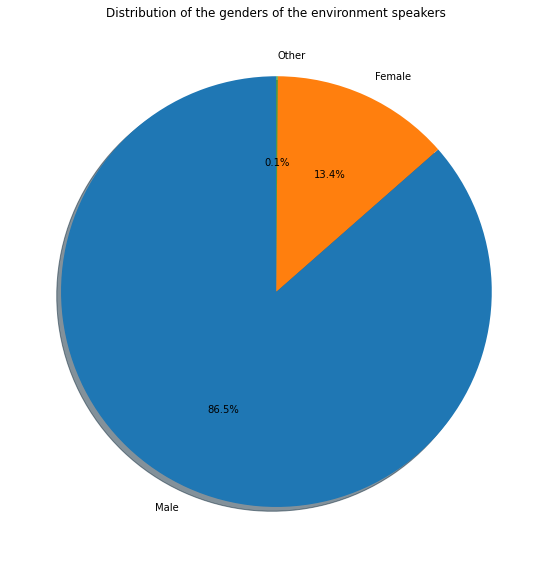

In [25]:
# Plot the distribution of the genders speaking of the environment
fig, ax = plt.subplots(figsize =  (14, 8))
ax.pie(environment_genders_counts, labels=np.array(['Male', 'Female', 'Other']), autopct='%1.1f%%',
        shadow=True, startangle=90)

ax.set_title('Distribution of the genders of the environment speakers')

fig.tight_layout()

Again the real information is shrouded behind the underlying distribution of male and female genders within the speakers in general. Let's check the ratios.

In [26]:
male_mask = all_speakers_grouped_by_gender.index == 'male'
female_mask = all_speakers_grouped_by_gender.index == 'female'
gender_total_counts = [
    all_speakers_grouped_by_gender[male_mask]['count'].sum(),
    all_speakers_grouped_by_gender[female_mask]['count'].sum(),
    all_speakers_grouped_by_gender[~(male_mask | female_mask)]['count'].sum()
]

gender_ratios = np.array(environment_genders_counts) / np.array(gender_total_counts)
gender_ratios

array([0.01630366, 0.00790721, 0.04154589])

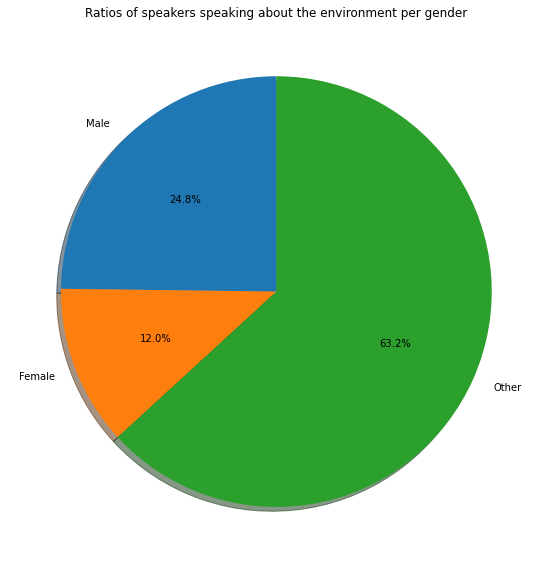

In [27]:
# Plot the distribution of the genders speaking of the environment
fig, ax = plt.subplots(figsize =  (14, 8))
ax.pie(gender_ratios * 100, labels=np.array(['Male', 'Female', 'Other']), autopct='%1.1f%%',
        shadow=True, startangle=90)

ax.set_title('Ratios of speakers speaking about the environment per gender')

fig.tight_layout()

**Findings**: Again when we look at the ratios per gender instead of the actual numbers, the information changes. We can see that **speakers from other genders other than male or female are more likely to speak about the environment**. However **males are still more likely to speak about the environment than females** according to the pie chart.

#### Academic degree

Here we will see if **having an academic degree** makes you more likely to speak about the environment or not.

In [28]:
# Re-use the function from previous part
environment_educated_speakers = environment_unique_speakers[environment_unique_speakers.academic_degree.apply(check_academic_degree)]
nb_environment_educated_speakers = len(environment_educated_speakers)
nb_environment_uneducated_speakers = len(environment_unique_speakers) - nb_environment_educated_speakers

display(nb_environment_educated_speakers)
display(nb_environment_uneducated_speakers)

1075

99487

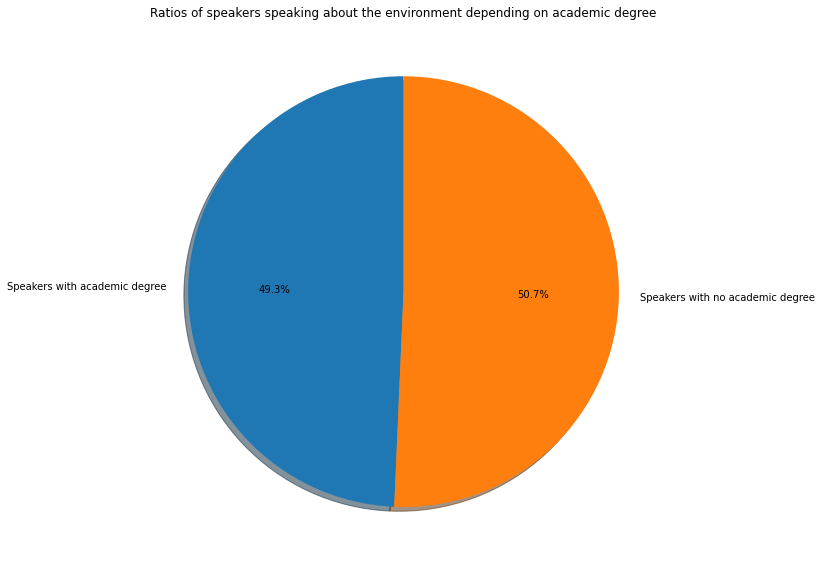

In [29]:
# Computing the ratios of speakers of environment based on academic degree
ratio_environment_educated = nb_environment_educated_speakers / nb_educated_speakers
ratio_environment_uneducated = nb_environment_uneducated_speakers / nb_uneducated_speakers

# Plot the distribution of the genders speaking of the environment
fig, ax = plt.subplots(figsize =  (14, 8))
ax.pie(np.array([ratio_environment_educated, ratio_environment_uneducated]) * 100,
       labels=np.array(['Speakers with academic degree', 'Speakers with no academic degree']), autopct='%1.1f%%',
       shadow=True, startangle=90)

ax.set_title('Ratios of speakers speaking about the environment depending on academic degree')

fig.tight_layout()

**Findings**: It seems a speaker is not more likely to mention the environment if he was educated than if he were not.

#### Nationality

In [30]:
top_nationalities_environment_speakers = group_and_sort_by_feature(environment_unique_speakers, ['nationality'])
top_nationalities_environment_speakers.head(n=20)

,count
nationality,
United States of America,25501
United Kingdom,14031
Australia,4782
Canada,4278
Ming dynasty,2827
India,2081
Germany,1707
New Zealand,1573
Ireland,1408


Now we compute the ratios of (#environment speakers / #all speakers) per nationality, only with the most prominent nationalities.

In [31]:
# Now the ratios per nationality
all_speakers_grouped_by_nationality = group_and_sort_by_feature(retrieved_labeled_speakers, ['nationality'])

ratios_by_nationalities = extract_and_sort_by_ratio(
            top_nationalities_environment_speakers,
            all_speakers_grouped_by_nationality[all_speakers_grouped_by_nationality['count'] > THRESHOLD]
)

display(
    'Ratio of speakers that have talked about the environment at least once, per nationality',
        ratios_by_nationalities.head(n=10)
)

'Ratio of speakers that have talked about the environment at least once, per nationality'

,count_environment,count_all,ratio
nationality,,,
Ireland,1408,14828,0.094955
Australia,4782,53093,0.090068
United Kingdom,14031,166656,0.084191
New Zealand,1573,23454,0.067067
United States of America,25501,438676,0.058132
Canada,4278,83369,0.051314
South Africa,538,14375,0.037426
India,2081,56687,0.036710
Tang Empire,877,37247,0.023546


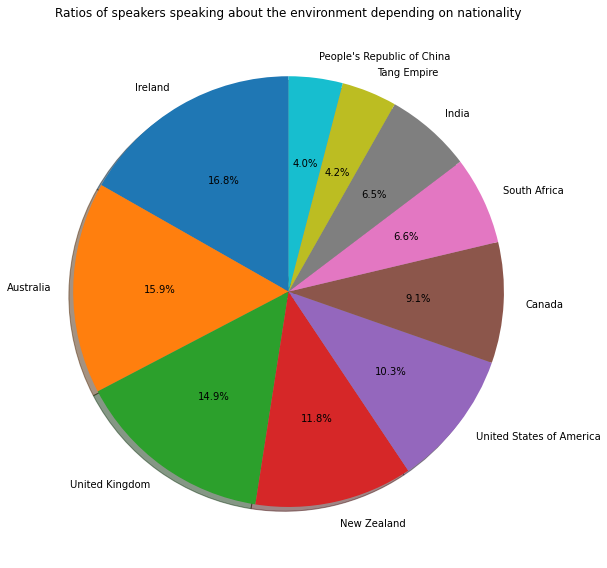

In [32]:
# Plot the distribution of the genders speaking of the environment based on nationality
fig, ax = plt.subplots(figsize =  (14, 8))
ax.pie((ratios_by_nationalities['ratio']*10).head(n=10),
       labels=ratios_by_nationalities.head(n=10).index, autopct='%1.1f%%',
       shadow=True, startangle=90)

ax.set_title('Ratios of speakers speaking about the environment depending on nationality')

fig.tight_layout()

**Findings**: The top countries where speakers are more likely to speak about the environment are usually **from the western hemisphere (politically speaking)**, like the USA, UK, Australia, NZ and Canada.

#### Age

In [33]:
environment_speakers_ages_grouped = group_and_sort_by_feature(environment_unique_speakers, ['age_group'])
environment_speakers_ages_grouped.head(n=20)

,count
age_group,
60s,13911
50s,13619
70s,10654
40s,10576
30s,8615
80s,5333
20s,4148
90s,2761
>=100,2021


In [34]:
ratios_by_age_groups = extract_and_sort_by_ratio(
            environment_speakers_ages_grouped, all_speakers_age_groups
)

display('Ratio of speakers that have talked about the environment at least once, per age group',
        ratios_by_age_groups.head(n=10)
       )

'Ratio of speakers that have talked about the environment at least once, per age group'

,count_environment,count_all,ratio
age_group,,,
50s,13619,385817,0.035299
60s,13911,403952,0.034437
40s,10576,353919,0.029883
70s,10654,380428,0.028005
30s,8615,335141,0.025706
80s,5333,277815,0.019196
20s,4148,252593,0.016422
90s,2761,262312,0.010526
10s,32,23548,0.001359


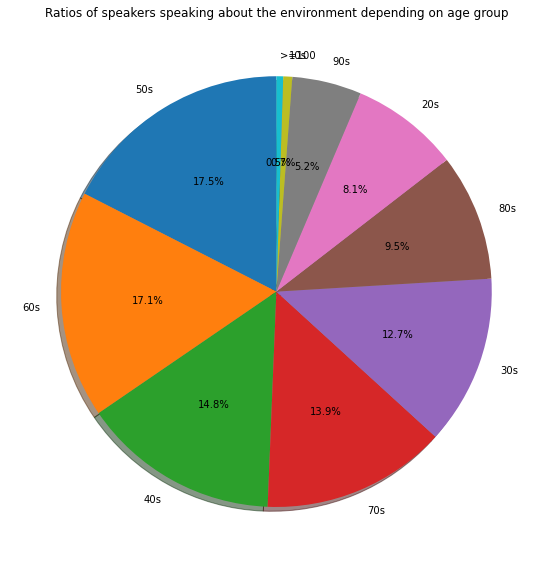

In [35]:
# Plot the distribution of the genders speaking of the environment based on age group
fig, ax = plt.subplots(figsize =  (14, 8))
ax.pie((ratios_by_age_groups['ratio']*10).head(n=10),
       labels=ratios_by_age_groups.head(n=10).index, autopct='%1.1f%%',
       shadow=True, startangle=90)

ax.set_title('Ratios of speakers speaking about the environment depending on age group')

fig.tight_layout()

**Findings**: A speaker's age group doesn't really change how likely he'd be speaking about the environment as we see the proportions aren't drastically different between the different age groups. **Yet a speaker in his 50s is doubly likely to quote the environment than a speaker in his 20s**.

And **if you're over a 100 years old** (probably a dead historical figure), the age group of which appears the most frequently in the speakers dataset, you are **very highly unlikely to have spoken about the environment. This shows the topic of the environment only came to prominence during the last century.**

#### Occupation & Age

To be fair, a lot of the speakers in our speakers dataset are over 100 years old, which means they're historical figures and the environment may not have been such a hot topic back then. Let's keep our interest to contemporary speakers, and redo our analysis using the speakers' occupations again.

In [37]:
# Filter out speakers of age > 100
environment_contemporary_speakers = environment_unique_speakers[environment_unique_speakers.age < 100]
all_contemporary_speakers = retrieved_labeled_speakers[retrieved_labeled_speakers.age < 100]

features = ['occupation', 'age_group']

# Redo the analysis on the speakers occupations
top_contemporary_speakers_by_occupation_and_age = group_and_sort_by_feature(all_contemporary_speakers, features)
top_environment_contemporary_speakers_by_occupation_and_age = group_and_sort_by_feature(
    environment_contemporary_speakers, features)
display('Number of contemporary speakers that have talked about the environment at least once, per occupation and age group',
        top_environment_contemporary_speakers_by_occupation_and_age.head(n=10))

# CAUTION: Set a threshold for the minimum number of speakers per age and occupation 
# (again to avoid having a speaker with a unique profile and thus having a high ratio if he speaks of the environment)
THRESHOLD = 5000

display('Ratio of speakers that have talked about the environment at least once, per occupation and age group',
        extract_and_sort_by_ratio(
            top_environment_contemporary_speakers_by_occupation_and_age,
            top_contemporary_speakers_by_occupation_and_age[
                top_contemporary_speakers_by_occupation_and_age['count'] >= THRESHOLD
            ]).head(n=10))

'Number of contemporary speakers that have talked about the environment at least once, per occupation and age group'

count
occupation                  age_group       
politician                  60s         2965
                            50s         2486
                            70s         2086
                            40s         1408
association football player 30s         1384
                            40s          985
                            50s          835
actor                       40s          824
writer                      60s          818
actor                       50s          806

'Ratio of speakers that have talked about the environment at least once, per occupation and age group'

count_environment  count_all     ratio
occupation               age_group                                        
American football player 30s                      693       6457  0.107325
lawyer                   60s                      520       5857  0.088783
businessperson           50s                      443       5203  0.085143
                         60s                      515       6156  0.083658
television actor         50s                      502       6002  0.083639
lawyer                   50s                      404       5210  0.077543
television actor         40s                      496       6811  0.072823
lawyer                   70s                      380       6066  0.062644
rugby union player       30s                      316       5175  0.061063
television actor         30s                      361       6009  0.060077

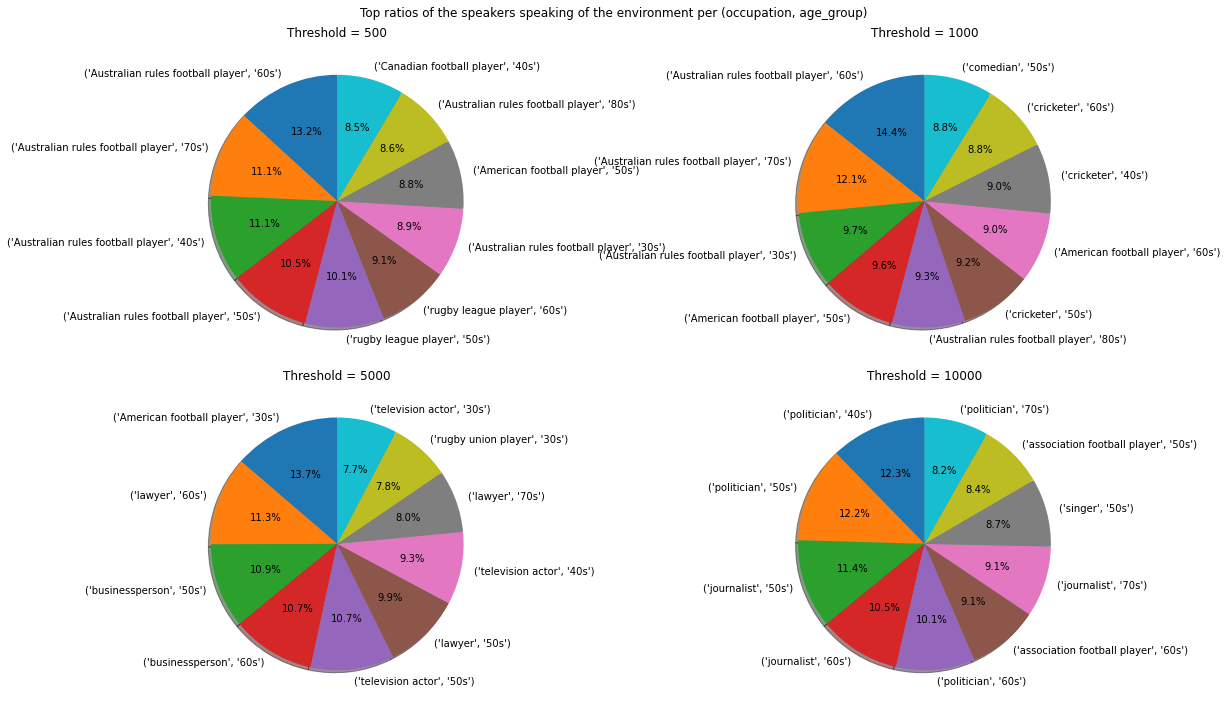

In [38]:
# Plot the ratios of the speakers speaking of the environment per (occupation, age_group) for different minimum thresholds
fig, axs = plt.subplots(nrows=2, ncols=2, figsize =(16, 10))
axs = axs.flatten()
thresholds = [500, 1000, 5000, 10000]

for threshold, ax in zip(thresholds, axs):
    ratios = extract_and_sort_by_ratio(
        top_environment_contemporary_speakers_by_occupation_and_age,
        top_contemporary_speakers_by_occupation_and_age[
            top_contemporary_speakers_by_occupation_and_age['count'] >= threshold
        ]).head(n=10)
    
    ax.pie(ratios['ratio'] * 10,
       labels=ratios.index, autopct='%1.1f%%',
       shadow=True, startangle=90)
    ax.set_title('Threshold = {}'.format(threshold))

fig.suptitle('Top ratios of the speakers speaking of the environment per (occupation, age_group)')
fig.tight_layout()

**Findings**: We have narrowed down the speakers by focusing only on contemporing speakers. Even so, we can see **it can become hard to extract a common profile of speakers who speak about the environment when we start combining features**. It depends heavily as well on the **threshold we set for the minumum number of speakers with a certain profile**.

For example a threshold of 500 means we don't take into account speakers who have a certain profile that have occurred less than 500 times. That's why we see profiles disappearing the more we up the threshold.

#### All attributes

Now we redo the analysis using simultaneously all the attributes explored so far, so that we have an idea about the most common speaker profile given all these features combined, namely **occupation, age, gender and nationality**. We don't into account the academic degree, since we've seen it doesn't change the likeability of a speaker speaking about the environment.

Note that this presents the problem we've mentioned during the caveat during preprocessing. Since we're exploding all the features in question, the distributions of one feature is going to become heavily affected by the distributions of other features. But it's a point for comparison.

In [39]:
features = ['occupation', 'age_group', 'gender', 'nationality']

# Redo the analysis on the speakers occupations
top_contemporary_speakers_by_features = group_and_sort_by_feature(all_contemporary_speakers, features)
top_environment_contemporary_speakers_by_features = group_and_sort_by_feature(
    environment_contemporary_speakers, features)
display('Number of contemporary speakers that have talked about the environment at least once, per profile',
        top_environment_contemporary_speakers_by_features.head(n=10))

'Number of contemporary speakers that have talked about the environment at least once, per profile'

count
occupation                  age_group gender nationality                    
politician                  60s       male   United States of America    843
                            70s       male   United States of America    647
American football player    30s       male   United States of America    639
association football player 30s       male   United Kingdom              624
politician                  50s       male   United States of America    607
association football player 50s       male   United Kingdom              520
                            40s       male   United Kingdom              504
American football player    40s       male   United States of America    481
                            50s       male   United States of America    454
association football player 60s       male   United Kingdom              421

In [40]:
# Set a general threshold 
THRESHOLD = 500
ratios_contemporary_speakers = extract_and_sort_by_ratio(
    top_environment_contemporary_speakers_by_features,
    top_contemporary_speakers_by_features[top_contemporary_speakers_by_features['count'] > THRESHOLD])

In [41]:
display('Ratio of speakers that have talked about the environment at least once, per profile',
        ratios_contemporary_speakers.head(n=10))

'Ratio of speakers that have talked about the environment at least once, per profile'

count_environment  \
occupation age_group gender nationality                                   
politician 60s       male   United Kingdom                          221   
                            Australia                               160   
           50s       male   United States of America                607   
           40s       male   United States of America                317   
           50s       female United States of America                171   
           60s       male   United States of America                843   
journalist 50s       male   United States of America                211   
politician 70s       male   Australia                               151   
cricketer  40s       male   United Kingdom                          209   
writer     50s       male   United Kingdom                          122   

                                                      count_all     ratio  
occupation age_group gender nationality                                    
politician 60s       male   United Kingdom                  697  0.317073  
                            Australia                       519  0.308285  
           50s       male   United States of America       2250  0.269778  
           40s       male   United States of America       1177  0.269329  
           50s       female United States of America        666  0.256757  
           60s       male   United States of America       3419  0.246563  
journalist 50s       male   United States of America        890  0.237079  
politician 70s       male   Australia                       639  0.236307  
cricketer  40s       male   United Kingdom                  922  0.226681  
writer     50s       male   United Kingdom                  541  0.225508

**Findings**: The problem we've highlighted in the previous point is even more pronounced here. By combining all the features together, it becomes very hard to extract a common speaker profile. And the results are very different for different thresholds of minumum amount of speakers of a certain profile.

### 3.3 - Thoughts on most common speaker profile speaking about the environment

It's quite easy to conclude on the likeability of a speaker speaking about the environment when **focusing on just one feature**. For example if we combine the results from each feature separately to construct a profile, we found **you're very likely to speak about the environment** if:
- **Occupation**: You're working in **Sports & Entertainment**
- **Gender**: You're **non-binary or transgender** (that is you don't identify as 'male' or 'female').
- **Academic degree**: It doesn't matter whether you have an academic degree.
- **Nationality**: You're from the **western hemisphere** politically speaking (USA, western Europe, Australia)
- **Age group**: You're **older than 40 years old**.

However when you start taking into account **multiple features and the interaction between them** to construct a complete profile, things aren't that clear anymore. We're faced with many issues:
- Since we're exploding all of the features in question, the distribution of one feature can easily pollute the distribution of another (e.g. a speaker with multiple occupations and just one gender).
- Since we're deriving the likeability that a speaker of certain profile actually speaks about the environment from the ratio of speakers of that profile speaking about the environment (i.e. = Number of speakers of profile A that spoke about the environment / total number of speakers of profile A), we have to choose a threshold of minimum number of speakers per profile. We cannot have a low threshold otherwise the ratio will be naturally very high and will pollute our results (e.g a speaker with a unique profile and speaks of the environment will have a ratio of 1!) How do we decide on the threshold of minimum number of speakers per profile?

## 4. Regression on Speaker's profiles

So far we've explored the speakers attributes to try to extract the most common profile of speakers who talk about the environment. Now we'll do this using regression analysis.

### 4.1 - Constructing a feature matrix X

A lot of our features are categorical (e.g occupation, nationality) and they have a lot of unique values. First for each feature we'll filter only the most prominent.

### 4.2 - Regressing on occupation

In [42]:
all_speakers_grouped_by_occupations

,count
occupation,
researcher,1693607
politician,589893
association football player,309608
actor,267074
writer,262005
...,...
The Pharmacist,0
kyūdōka,0
Kobzar,0
